In [1]:
# -- coding: utf-8 --
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
#
# Code adapted from QizGloria team, Qiskit Camp Europe 2019, updated by 
# Team Ube Pancake, Qiskit Summer Jam 2020
#
# WORKS for Quantum Circuit with variable number of qubits! Now supports running on GPU (CUDA)

In [1]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

# if torch.cuda.is_available():
#     device = torch.device("cuda:0")
#     print("Running on the GPU")
# else:
#     device = torch.device("cpu")
#     print("Running on the CPU")
    
# torch.device("cpu")

In [2]:
from qiskit import execute
from qiskit.circuit import Parameter,QuantumCircuit
from qiskit import Aer
import qiskit
import numpy as np

In [3]:
from tqdm import tqdm

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [114]:
np.random.seed = 42

NUM_QUBITS = 2
NUM_CIRCUITS = 3
NUM_SHOTS = 10000
SHIFT = 0.9
LEARNING_RATE = 0.01
MOMENTUM = 0.5
SIMULATOR = Aer.get_backend('qasm_simulator')

In [6]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['00', '01', '10', '11']


Define function to translate Q-Circuit parameters from pytorch back to QISKIT

## 3. Contruct QuantumCircuit Class

In [7]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

class QiskitCircuit():
    def __init__(self, n_qubits, backend, shots):
        self.beta = Parameter('Beta')
        self.gamma = Parameter('Gamma')
        self.shots = shots
        
        def create_circuit():
            ckt = QuantumCircuit(2, 2)
            # add mixer part
            ckt.rx(self.beta, 0)
            ckt.rx(self.beta, 1)

            # add H_target part, for each Zi Zj do this
            ckt.cx(0,1)
            ckt.rz(-1*self.gamma, 1)
            ckt.cx(0,1)
            ckt.measure([0,1],[0,1])
            return ckt

        self.circuit = create_circuit()
    
    def energy_expectation(self, counts, shots, i,j, Cij=-1): #calculate expectation for one qubit pair
        expects = 0
        #print(counts)
        for key in counts.keys():
            perc = counts[key]/shots
            check = Cij*(float(key[i])-1/2)*(float(key[j])-1/2)*perc
            expects += check   
        return [expects] 
    
    def bind(self,parameters):
        [self.beta,self.gamma] = parameters
        #print(self.circuit.data)
        self.circuit.data[0][0]._params = to_numbers(parameters)[0:1]
        self.circuit.data[1][0]._params = to_numbers(parameters)[0:1]
        self.circuit.data[3][0]._params = to_numbers(parameters)[1:2]
        return self.circuit
 
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        #print(counts)
        return self.energy_expectation(counts, self.shots, 0,1)   

Expected value for rotation [pi/4]: [-0.1272]


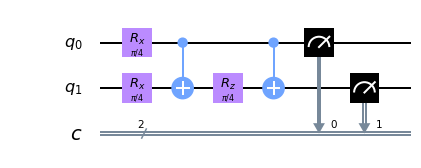

In [8]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl', filename='Figures/{}-qubit circuit ryN.jpg'.format(NUM_QUBITS))

### TorchCircuit()

A pytorch layer always has two functions. One for the forward pass and one for the backward pass. The forward pass simply takes the Quantum Circuits variational parameters from the previous pytorch layer and runs the circuit on the defined hardware (defined in `QiskitCircuit.run()`) and returns the measurements from the quantum hardware.
These measurements will be the inputs of the next pytorch layer.

The backward pass returns the gradients of the quantum circuit. In this case here it is finite difference.

the `forward_tensor` is saved from the forward pass. So we just have to do one evaluation of the Q-Circuit in the backpass for the finite difference.

The `gradient` variable here is as well hard coded to 3 parameters. This should be updated in the future and made more general.

The loop `for k in range(len(input_numbers)):` goes through all the parameters (in this case 3), and shifts them by a small $\epsilon$. Then it runs the circuit and takes the diefferences of the ouput for the parameters $\Theta$ and $\Theta + \epsilon$. This is the finite difference. 

In [9]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
        
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
#             print('shift_right = {}, shift_left = {}'.format(shift_right, shift_left))
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
#             print('expectation_right = {}, \nexpectation_left = {}'.format(expectation_right, expectation_left))
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])*2
            # rescale gradient
#             gradient = gradient / torch.norm(gradient)
#             print('gradient for k={}: {}'.format(k, gradient))
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
#         print('gradients = {}'.format(result))
#         print('grad_output = {}'.format(grad_output))

        return (result.float() * grad_output.float()).T

In [10]:
x = torch.tensor([np.pi/4]*NUM_QUBITS, requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
print('y1 after quantum layer: {}'.format(y1))
y1 = nn.Linear(1,1)(y1.float())
y1.backward()
print('x.grad = {}'.format(x.grad))

y1 after quantum layer: tensor([[-0.1246]], grad_fn=<TorchCircuitBackward>)
x.grad = tensor([-0.4048, -0.1036])


### Test the Quantum Circuit's Gradient Descent

First, we want the "neural net" consisting of just the quantum circuit (with its 4 inputs and 4 outputs) and a linear layer (from 4 inputs to 1 output) that scales measurement 1 by 1, measurement 2 by 2, etc., until it converges to a target value (-1). So, we define a cost function where the cost is defined as the square distance from the target value.

`x` is the initialization of the parameters. Here, every angle in the quantum circuit starts at $\pi/4$. We should see that the loss eventually goes down.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.25it/s]


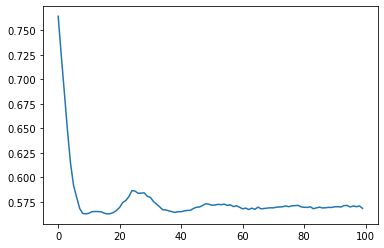

In [11]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    # simple linear layer: average all outputs of quantum layer
#     print(expval)
    val = expval
#     print(val)
    return torch.abs(val - target) ** 2, expval

x = torch.tensor([-np.pi/4]*NUM_QUBITS, requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
# for i in range(num_epoch):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)

plt.plot(loss_list)

### MNIST in pytorch

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Load MNIST (0-1) Dataset

**Training Data**

In [314]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

# Concentrating on the first 100 samples
n_samples = 150

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

**Testing Data**

In [315]:
n_samples = 200

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][n_samples:], 
                np.where(X_test.targets == 1)[0][n_samples:])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

### Define Neural Network with Q-node

This NN is  2 layers of ConvNN and a fully connected layer, with a Q-Node as a classifier.

In [329]:
NUM_CIRCUITS = 3

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS*NUM_CIRCUITS*2)
        self.fake_qc = nn.Linear(NUM_QUBITS, NUM_CIRCUITS)
        self.qc = TorchCircuit.apply
        self.out = nn.Linear(NUM_CIRCUITS, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = torch.tanh(x) # rescale to [-1, 1] to get sin(theta), cos(theta) for each angle
        x = x.view(-1) # flatten to 1D tensor
        x = torch.cat([(x[i * 2 : i*2 + 2]) / torch.norm(x[i * 2: i*2 + 2]) 
                       for i in range(NUM_CIRCUITS*2)], dim=-1) # normalize sin and cos for each angle
        x = torch.stack([torch.atan2(x[i * 2], x[i*2 + 1]) for i in range(NUM_CIRCUITS*2)]) # convert to angles
        x = torch.cat([qc(x[i * 2 : i*2 + 2]) for i in range(NUM_CIRCUITS)], dim=1) # QUANTUM LAYER

#         x = self.fake_qc(x)
    
#         x = self.qc(x[0])
        x = self.out(x)
        return F.log_softmax(x)

    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net()#.to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01,
                      momentum=0.6)

# optimizer = optim.Adam(network.parameters(), lr=0.0003)



In [330]:
epochs = 5
loss_list = []
loss_func = F.nll_loss

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, position=0, leave=True)):
#         print(batch_idx)
#         target = target.float()
        optimizer.zero_grad()        
        # Forward pass
        output = network(data)
        # Calculating loss
#         print(target)
#         print(output, target)
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Training [20%]	Loss: 0.6765


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Training [40%]	Loss: 0.5759


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Training [60%]	Loss: 0.4885


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Training [80%]	Loss: 0.4249


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:37<00:00,  3.06it/s]

Training [100%]	Loss: 0.3781


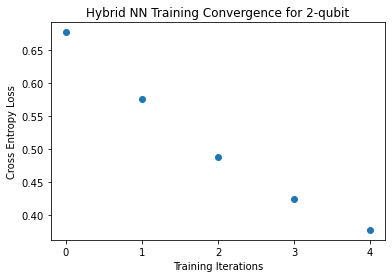

In [331]:
plt.plot(loss_list, 'o')
plt.xticks(range(epochs))
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.savefig('Figures/{}-qubit Loss Curve QAOA.jpg'.format(NUM_QUBITS))

### Test accuracy of NN

The outcome is not always the same because the prediction is probabilistic.

In [332]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(tqdm(test_loader, position=0, leave=True)):
    number +=1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1

100%|██████████████████████████████████████████████████████████████████████████████| 1715/1715 [01:54<00:00, 15.03it/s]


In [333]:
print("Performance on test data is is: {}/{} = {}%".format(accuracy,number,100*accuracy/number))    

Performance on test data is is: 1711/1715 = 99.76676384839651%


C:\Users\Edward\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


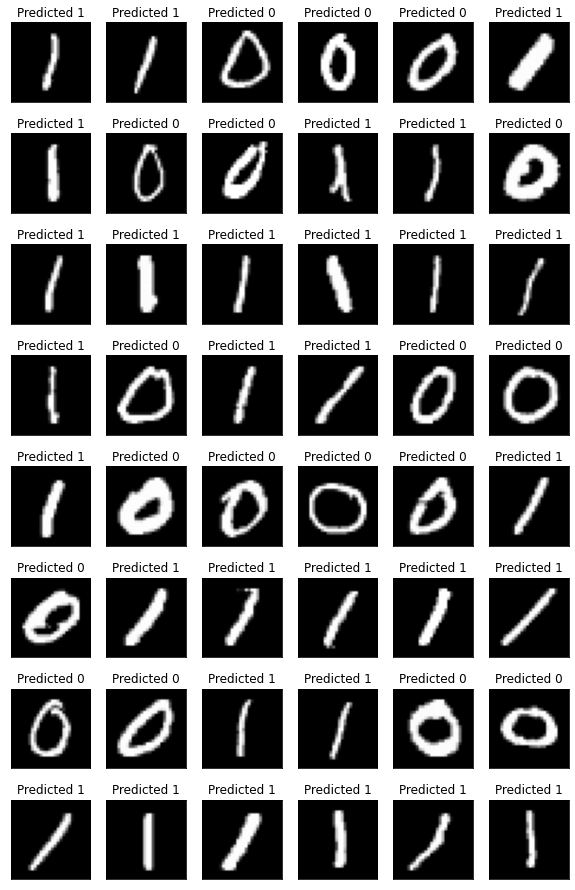

In [334]:
n_samples_shape = (8, 6)
count = 0
fig, axes = plt.subplots(nrows=n_samples_shape[0], ncols=n_samples_shape[1], figsize=(10, 2*n_samples_shape[0]))

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_shape[0]*n_samples_shape[1]:
            break
        pred = network.predict(data).item()

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_xticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_yticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_title('Predicted {}'.format(pred))
        
        count += 1

## MNIST 0-9

### Load Data

In [543]:
n_samples = 250

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.stack([np.where(X_train.targets == i)[0][:n_samples] for i in range(10)], axis=1)
idx = idx.reshape(-1)

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

n_samples = 200

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.stack([np.where(X_test.targets == i)[0][:n_samples] for i in range(10)])
idx = idx.reshape(-1)

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

### Define Network

In [544]:
NUM_CIRCUITS = 5
NUM_CLASSES = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(20)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS*NUM_CIRCUITS*2)
        self.fake_qc = nn.Linear(NUM_QUBITS*NUM_CIRCUITS*2, NUM_CIRCUITS)
        self.qc = TorchCircuit.apply
        self.out = nn.Linear(NUM_CIRCUITS, NUM_CLASSES)

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.leaky_relu(F.max_pool2d(self.conv2_drop(self.bn2(self.conv2(x))), 2))
        x = x.view(-1, 320)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        
#         x = self.fake_qc(x)
        
        x = torch.tanh(x) # rescale to [-1, 1] to get sin(theta), cos(theta) for each angle
        x = x.view(-1) # flatten to 1D tensor
        x = torch.cat([(x[i * 2 : i*2 + 2]) / torch.norm(x[i * 2: i*2 + 2]) 
                       for i in range(NUM_CIRCUITS*2)], dim=-1) # normalize sin and cos for each angle
        x = torch.stack([torch.atan2(x[i * 2], x[i*2 + 1]) for i in range(NUM_CIRCUITS*2)]) # convert to angles
        x = torch.cat([qc(x[i * 2 : i*2 + 2]) for i in range(NUM_CIRCUITS)], dim=1) # QUANTUM LAYER
        
        x = self.out(x)
        return F.log_softmax(x)

    def predict(self, x):
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)

  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Training [20%]	Loss: 2.2907


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Training [40%]	Loss: 2.2452


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Training [60%]	Loss: 2.2012


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

Training [80%]	Loss: 2.1476


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [22:04<00:00,  1.89it/s]


Training [100%]	Loss: 2.0861


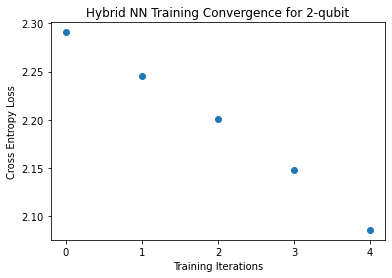

In [545]:
network = Net()#.to(device)
# optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.6)
optimizer = optim.Adam(network.parameters(), lr=0.0003)

epochs = 5
loss_list = []
loss_func = F.nll_loss

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, position=0, leave=True)):
        optimizer.zero_grad()        
        output = network(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))
    
plt.plot(loss_list, 'o')
plt.xticks(range(epochs))
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.savefig('Figures/{}-qubit Loss Curve QAOA.jpg'.format(NUM_QUBITS))

In [546]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(tqdm(test_loader, position=0, leave=True)):
    number +=1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:37<00:00,  9.19it/s]


In [547]:
print("Performance on test data is is: {}/{} = {}%".format(accuracy,number,100*accuracy/number))    

Performance on test data is is: 1046/2000 = 52.3%


RuntimeError: size mismatch, m1: [1 x 5], m2: [10 x 10] at C:\cb\pytorch_1000000000000\work\aten\src\TH/generic/THTensorMath.cpp:41

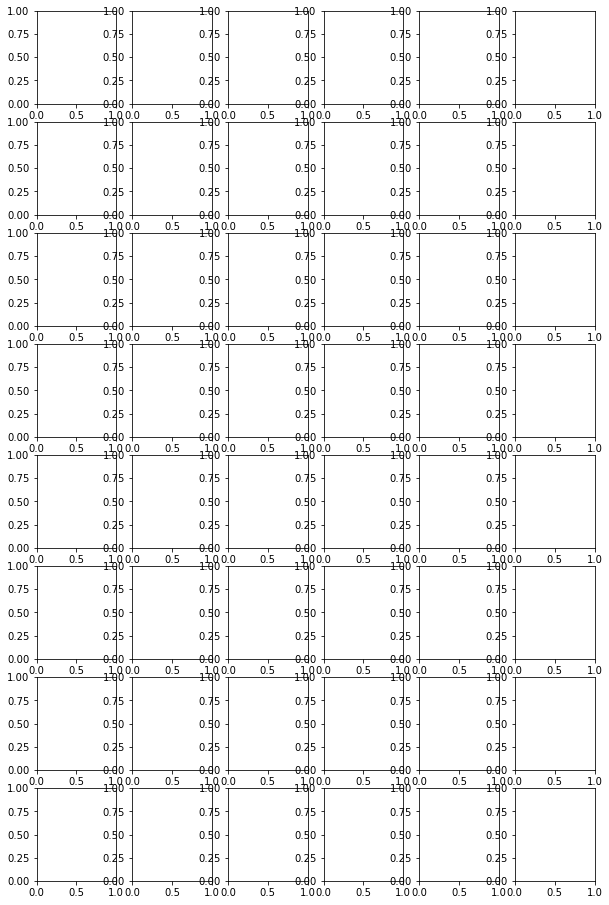

In [413]:
n_samples_shape = (8, 6)
count = 0
fig, axes = plt.subplots(nrows=n_samples_shape[0], ncols=n_samples_shape[1], figsize=(10, 2*n_samples_shape[0]))

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_shape[0]*n_samples_shape[1]:
            break
        pred = network.predict(data).item()

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_xticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_yticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_title('Predicted {}'.format(pred))
        
        count += 1

## Quantum Denoising Autoencoder

In [458]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# # convert data to torch.FloatTensor
# transform = transforms.ToTensor()

# # load the training and test datasets
# train_data = datasets.MNIST(root='data', train=True,
#                                    download=True, transform=transform)
# test_data = datasets.MNIST(root='data', train=False,
#                                   download=True, transform=transform)

# # Create training and test dataloaders
# num_workers = 0
# # how many samples per batch to load
# batch_size = 20

# # prepare data loaders
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [520]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

# Concentrating on the first 100 samples
n_samples = 500

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)



In [521]:
n_samples = 200

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][n_samples:], 
                np.where(X_test.targets == 1)[0][n_samples:])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

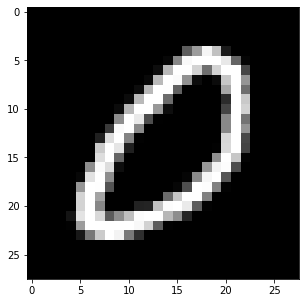

In [522]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [528]:
import torch.nn as nnleaky_relu
import torch.nn.functional as F

NUM_CIRCUITS=5

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()

        n_filters = 32
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, n_filters, 3, padding=1)
        self.conv2 = nn.Conv2d(n_filters, 4, 3, padding=1)
        self.conv3 = nn.Conv2d(4, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc2 = nn.Linear(36, NUM_QUBITS*NUM_CIRCUITS*2)
        self.fake_qc = nn.Linear(NUM_QUBITS*NUM_CIRCUITS*2, NUM_CIRCUITS)
        
        self.qc = TorchCircuit.apply
        self.out = nn.Linear(NUM_CIRCUITS, 36)

        ## decoder layers ##
        self.t_conv0 = nn.ConvTranspose2d(4, 4, 3, stride=2)
        self.t_conv1 = nn.ConvTranspose2d(4, n_filters, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(n_filters, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.pool(x)
        x = nn.Flatten()(x)
        ## quantum ##
        
        x = self.fc2(x)
        
#         x = self.fake_qc(x)
        
        x = torch.tanh(x) # rescale to [-1, 1] to get sin(theta), cos(theta) for each angle
        x = x.view(-1) # flatten to 1D tensor
        x = torch.cat([(x[i * 2 : i*2 + 2]) / torch.norm(x[i * 2: i*2 + 2]) 
                       for i in range(NUM_CIRCUITS*2)], dim=-1) # normalize sin and cos for each angle
        x = torch.stack([torch.atan2(x[i * 2], x[i*2 + 1]) for i in range(NUM_CIRCUITS*2)]) # convert to angles
        x = torch.cat([qc(x[i * 2 : i*2 + 2]) for i in range(NUM_CIRCUITS)], dim=1) # QUANTUM LAYER

        x = self.out(x)
        x = x.view(-1, 4, 3, 3)
        
        ## decode ##
        x = F.leaky_relu(self.t_conv0(x))        
        x = F.leaky_relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
       
        return x

# initialize the NN
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=36, out_features=20, bias=True)
  (fake_qc): Linear(in_features=20, out_features=5, bias=True)
  (out): Linear(in_features=5, out_features=36, bias=True)
  (t_conv0): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(2, 2))
  (t_conv1): ConvTranspose2d(4, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [529]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def add_gaussian_noise(images, sigma=0.5):
    return torch.clamp(torch.distributions.Normal(0, sigma).sample(images.shape) + images, 0., 1.)

from tqdm import tqdm

# number of epochs to train the model
n_epochs = 5

# for adding noise to images

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in tqdm(train_loader, position=0, leave=True):
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images TODO
        noisy_imgs = add_gaussian_noise(images)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.095639


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.060810


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.050662


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.043991


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:28<00:00,  1.76it/s]

Epoch: 5 	Training Loss: 0.040549


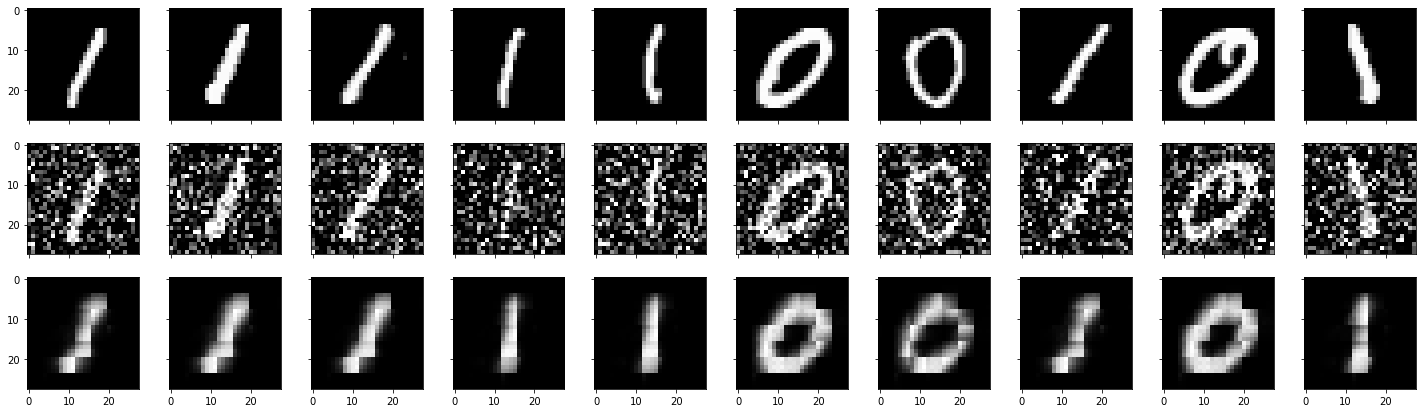

In [531]:
# plot the first ten input images and then reconstructed images
ncols = 10
fig, axes = plt.subplots(nrows=3, ncols=ncols, sharex=True, sharey=True, figsize=(25,7))
    
for k in range(ncols):
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    # add noise to the test images TODO
    noisy_imgs = add_gaussian_noise(images)

    # get sample outputs
    output = model(noisy_imgs)
    # prep images for display
    noisy_imgs = noisy_imgs.numpy()

    # output is resized into a batch of iages
    output = output.view(1, 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.detach().numpy()

    col_axes = axes[:, k]
    
    col_axes[0].imshow(np.squeeze(images), cmap='gray')
    col_axes[1].imshow(np.squeeze(noisy_imgs), cmap='gray')
    col_axes[2].imshow(np.squeeze(output), cmap='gray')
#         noisy = noisy_imgs.reshape(28, 28)
#         plt.figure()
#         plt.imshow(np.squeeze(noisy_imgs), cmap='gray')
#         plt.show()
#         for img, ax in zip(noisy_imgs, row):
#             ax.imshow(np.squeeze(img), cmap='gray')
#             ax.get_xaxis().set_visible(False)
#             ax.get_yaxis().set_visible(False)

plt.savefig('Figures/denoised_inputs.png')